## ДЗ 2. Преобразование признаков 

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

### 1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

### 2. Оцените ошибку модели из п.1 .

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

In [3]:
data = pd.read_csv('my_PJME_MW.csv',parse_dates={'Date-time': [0,1]}, index_col='Date-time')

In [4]:
data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date-time,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [5]:
data.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


Общий вид изменения ключевого свойства ряда приведен на рис.1.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


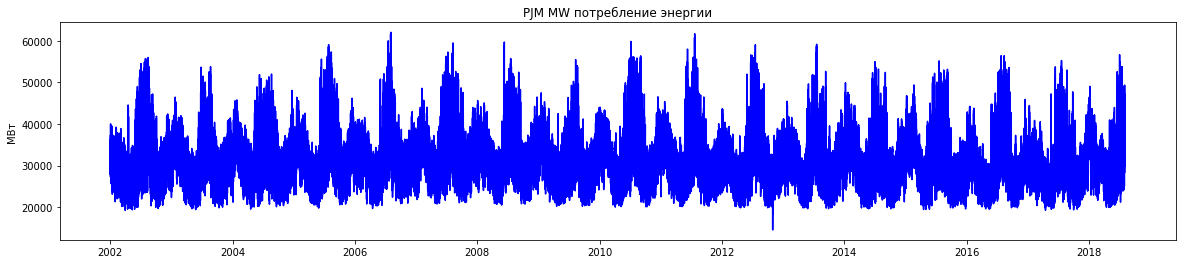

In [6]:
plt.figure(figsize =(20,4))
plt.plot(data.index, data['PJME_MW'], 'b' )
plt.title('PJM MW потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

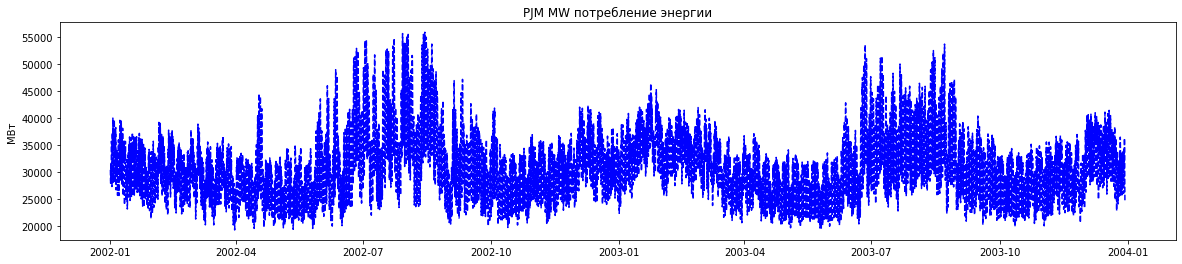

In [7]:
date_time =data['PJME_MW']
date_time.index = pd.date_range(data.index[0], periods=data.index.shape[0], freq="H")
plt.figure(figsize =(20,4))
plt.plot( date_time.index[:24*7*104], date_time.values[:24*7*104], '--b' )

plt.title('PJM MW потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [8]:
en_ar = data['PJME_MW'].values
en_s = pd.DataFrame(data = data[['PJME_MW']])

In [9]:
en_s.head()

,PJME_MW
Date-time,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [10]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [11]:
d_data=data.resample('D').mean()

Text(0.5, 1.0, 'PJM MW потребление энергии 2002-2019')

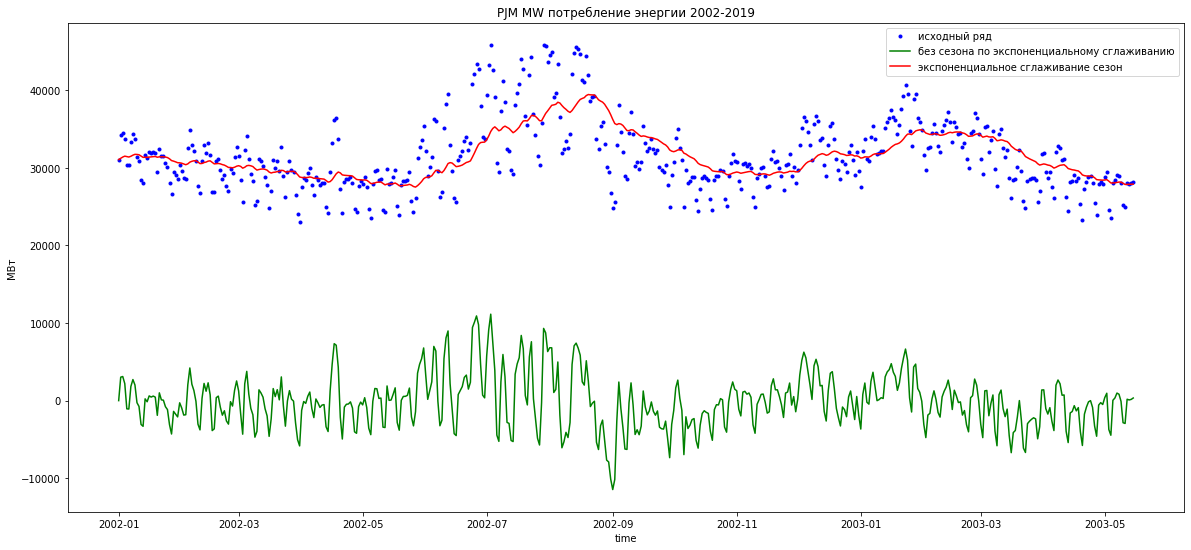

In [12]:
data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b',label='исходный ряд')
plt.plot(d_data.index[:500],d_data['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");
plt.plot(d_data.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('МВт')
plt.legend()
plt.title('PJM MW потребление энергии 2002-2019')

In [13]:
df= pd.DataFrame(data_exp_1, index = d_data.index, columns=['Wt'])
df.head()

,Wt
Date-time,
2002-01-01,31080.739130
2002-01-02,31239.779257
2002-01-03,31403.384044
2002-01-04,31518.987759
2002-01-05,31463.294621


In [14]:
 # добавиv историю на глубину 5 измерения от текущего (р=5)
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df['t3']=0
df.iloc[4:,4]=df.iloc[:-4,0].values
df['t4']=0
df.iloc[5:,5]=df.iloc[:-5,0].values
df.fillna(0)

# добавим разности - 1-й порядок
#df['diff1'] = 0
#df['diff1'].iloc[1:] = df.iloc[:-1,0]-df.iloc[1:,0]

df.head()

,Wt,t,t1,t2,t3,t4
Date-time,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,0.00000,0.0
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,0.00000,0.0
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,0.00000,0.0
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,0.00000,0.0
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31080.73913,0.0


In [15]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date-time') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date-time') >  split_date].copy()

In [16]:
SPLIT_DATA = '2017-01-01'
SPLIT_DATA_next = '2017-01-02'

In [17]:
train, test = split_data(df, SPLIT_DATA)

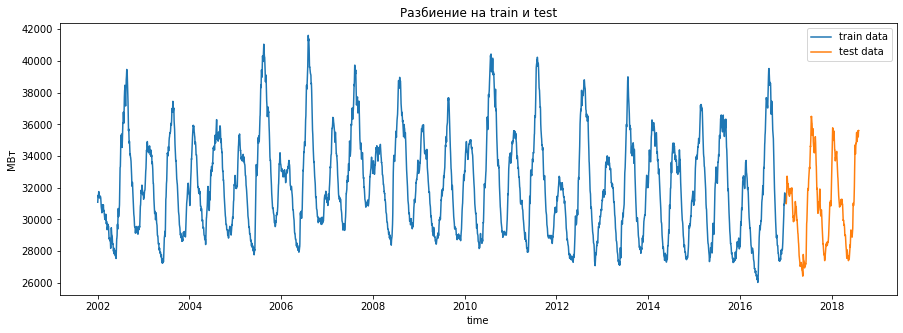

In [18]:
plt.figure( figsize=(15, 5))
plt.xlabel('time')
plt.ylabel('МВт')
plt.plot(train.index, train[df.columns[0]], label='train data' )
plt.plot(test.index, test[df.columns[0]], label='test data')
plt.title('Разбиение на train и test')
plt.legend()
plt.show()

In [19]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
def model_season(h, train=train, test=test):
    X_train = train.iloc[:-h,:]
    y_train = train[df.columns[0]].values[h:]
    X_test = test.iloc[:-h,:]
    y_test = test[df.columns[0]].values[h:]
    
    model_gb.fit( X_train, y_train ) 
    X_test_pred = model_gb.predict(X_test)
    
    plt.figure(figsize=(15, 5))
    plt.xlabel('time')
    plt.ylabel('МВт')
    plt.plot(test.index[h:],X_test_pred, label='predict GB data' )
    plt.plot(test.index[h:],y_test, label='test data')
    plt.plot(d_data.loc[SPLIT_DATA_next:].index, d_data.loc[SPLIT_DATA_next:]['PJME_MW'], label='исходный ряд')
    plt.legend()
    plt.show()

    er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred)
    print(f'h={h} - ошибка градиентного бустинга = {er_g} %')

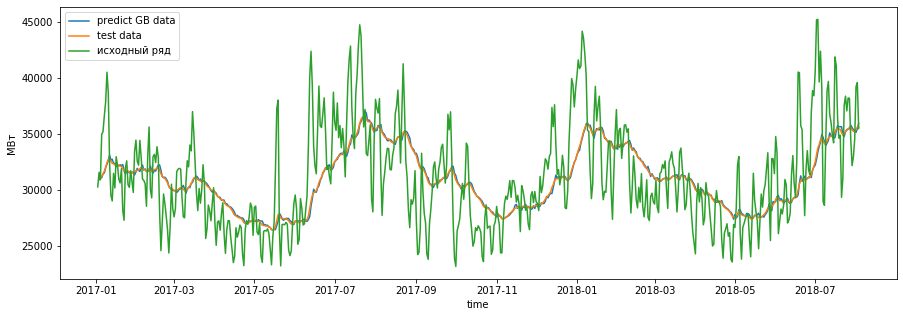

h=1 - ошибка градиентного бустинга = 0.4324006249376036 %


In [22]:
model_season(1)

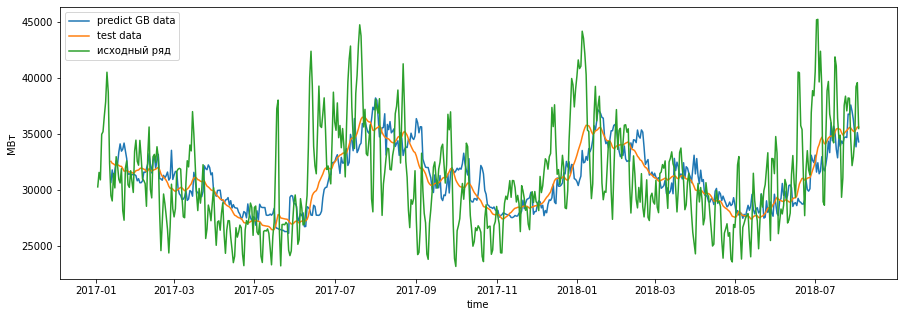

h=10 - ошибка градиентного бустинга = 3.1639744578211304 %


In [23]:
model_season(10)

### 3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

***С увеличением глубины прогноза с h=1 до h=10 ошибка заметно увеличивается. Значит предсказательная сила модели падает для значений, которые находятся на большем удалении от истории.***

### 4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

#### а) Изменение температуры за окном :).

Cтационарный ряд. Сезонность есть (времена года), цикл есть (день/ночь), тренда нет (глобальное потепление, во-первых, спорно, а, во-вторых, может влиять по-разном уна территории).

#### б) Количество денег, которые тратят покупатели в интернет магазине.

Не стационарный. Сезонность есть (предпраздничные дни, если речь не идет о товарах повседневного спроса), цикл - год, тренд есть (коичество интернет-продаж растет). 

#### в) Вес растущего котенка.

Не стационарный. Сезонности и цикла, тренд есть (вес, особенно первые пару лет растет).

#### г) Прирост объема деревьев в лесу от времени.

Если не учитывать различные вероятные сдерживающие факторы (пожары, ограниченность лесной зоны застройками/полями, изменением почвенного состава, смена климатических зон и тп.).
Cтационарный ряд. Сезонность есть (времена года, новые деревья всходят весной), цикла нет, тренд (в случае не ограниченной естественными или искуственными причинами площади для распространения) есть - восходящий. 